In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import LabelEncoder
import itertools
import warnings

In [35]:
file_path = "../data/plant_health_data.csv"
# Charger le fichier CSV
df = pd.read_csv(file_path, sep=',', header=0)

df.head()

,Timestamp,Plant_ID,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal,Plant_Health_Status
0,2024-10-03 10:54:53.407995,1,27.521109,22.240245,21.900435,55.291904,556.172805,5.581955,10.003650,45.806852,39.076199,35.703006,0.941402,High Stress
1,2024-10-03 16:54:53.407995,1,14.835566,21.706763,18.680892,63.949181,596.136721,7.135705,30.712562,25.394393,17.944826,27.993296,0.164899,High Stress
2,2024-10-03 22:54:53.407995,1,17.086362,21.180946,15.392939,67.837956,591.124627,5.656852,29.337002,27.573892,35.706530,43.646308,1.081728,High Stress
3,2024-10-04 04:54:53.407995,1,15.336156,22.593302,22.778394,58.190811,241.412476,5.584523,16.966621,26.180705,26.257746,37.838095,1.186088,High Stress
4,2024-10-04 10:54:53.407995,1,39.822216,28.929001,18.100937,63.772036,444.493830,5.919707,10.944961,37.898907,37.654483,48.265812,1.609805,High Stress


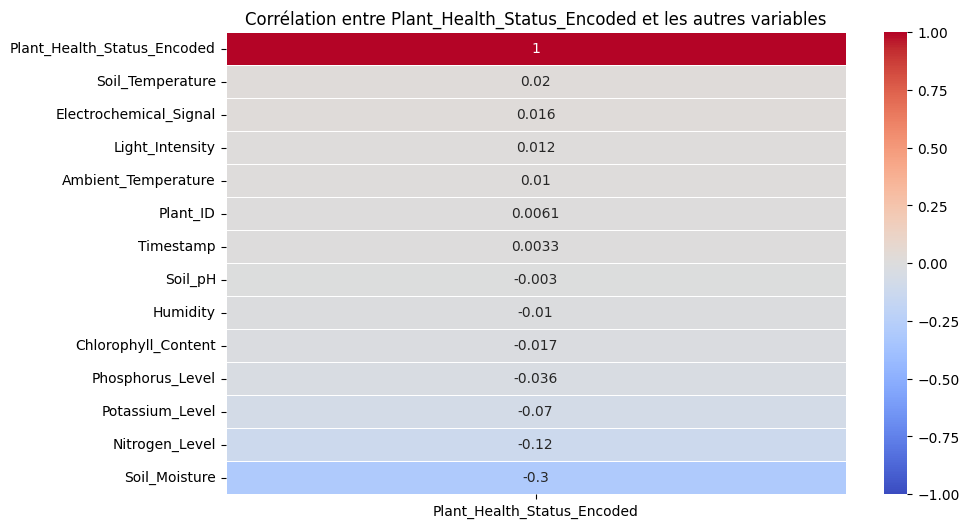

Plant_Health_Status_Encoded    1.000000
Soil_Temperature               0.019565
Electrochemical_Signal         0.016194
Light_Intensity                0.011885
Ambient_Temperature            0.010043
Plant_ID                       0.006116
Timestamp                      0.003265
Soil_pH                       -0.003037
Humidity                      -0.010071
Chlorophyll_Content           -0.017020
Phosphorus_Level              -0.036100
Potassium_Level               -0.070483
Nitrogen_Level                -0.117730
Soil_Moisture                 -0.297279
Name: Plant_Health_Status_Encoded, dtype: float64


In [36]:
# Convertir la colonne Timestamp en datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Calculer la matrice de corrélation
correlation_matrix = df.drop(columns=['Plant_Health_Status']).corr()

label_encoder = LabelEncoder()
df['Plant_Health_Status_Encoded'] = label_encoder.fit_transform(df['Plant_Health_Status'])

# Calculer la matrice de corrélation
correlation_matrix = df.drop(columns=['Plant_Health_Status']).corr()

# Filtrer uniquement les corrélations avec la variable cible
correlation_with_target = correlation_matrix['Plant_Health_Status_Encoded'].sort_values(ascending=False)

# Afficher les corrélations sous forme de heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Corrélation entre Plant_Health_Status_Encoded et les autres variables")
plt.show()

# Afficher les variables les plus corrélées avec Plant_Health_Status_Encoded
print(correlation_with_target)



In [47]:
# 🔹 2. Fonction pour tester la stationnarité
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    return result[1] < 0.05  # Retourne True si la série est stationnaire


# 🔹 3. Détermination automatique des meilleurs paramètres ARIMA
def determine_best_arima_params(data):
    p = d = q = range(0, 3)  # Tester des valeurs entre 0 et 2
    pdq_combinations = list(itertools.product(p, d, q))
    best_aic = float("inf")
    best_order = None
    
    for order in pdq_combinations:
        try:
            model = ARIMA(data, order=order)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
        except:
            continue
    
    return best_order if best_order else (1, 0, 1)




In [51]:
# 🔹 4. Entraînement du modèle ARIMA pour chaque plante
best_models = {}
forecast_results = {}

for plant_id in df['Plant_ID'].unique():
    df_plant = df[df['Plant_ID'] == plant_id].copy()
    
    # Déterminer les meilleurs paramètres ARIMA
    best_p, best_d, best_q = determine_best_arima_params(df_plant['Plant_Health_Status_Encoded'])
    print(f'  → Paramètres sélectionnés: p={best_p}, d={best_d}, q={best_q}')
    warnings.filterwarnings("ignore")
    
    # Entraîner le modèle ARIMA
    model = ARIMA(df_plant['Plant_Health_Status_Encoded'], order=(best_p, best_d, best_q))
    model_fit = model.fit()
    best_models[plant_id] = model_fit
    
    # Prédire pour les 10 prochaines périodes
    forecast = model_fit.forecast(steps=10)
    forecast_results[plant_id] = forecast



/opt/anaconda3/envs/we_plant_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/we_plant_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/we_plant_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/we_plant_env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

  → Paramètres sélectionnés: p=2, d=0, q=0
  → Paramètres sélectionnés: p=2, d=0, q=2
  → Paramètres sélectionnés: p=1, d=0, q=0
  → Paramètres sélectionnés: p=0, d=0, q=0
  → Paramètres sélectionnés: p=1, d=0, q=0
  → Paramètres sélectionnés: p=0, d=0, q=0
  → Paramètres sélectionnés: p=0, d=0, q=0
  → Paramètres sélectionnés: p=0, d=0, q=2
  → Paramètres sélectionnés: p=2, d=0, q=2
  → Paramètres sélectionnés: p=2, d=0, q=2



🔮 Prédictions ARIMA pour Plant_ID 1:
120    1.224742
121    0.979587
122    1.171613
123    1.145040
124    1.176132
125    1.174105
126    1.179328
127    1.179410
128    1.180322
129    1.180412
Name: predicted_mean, dtype: float64


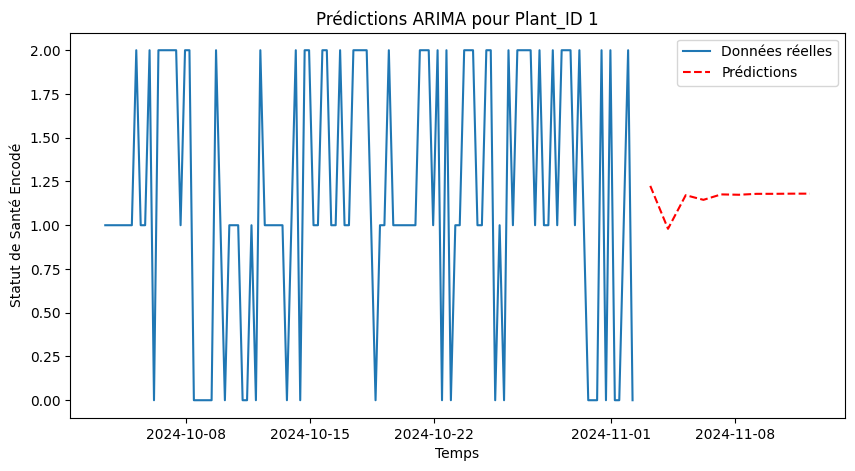


🔮 Prédictions ARIMA pour Plant_ID 2:
120    1.127143
121    1.417331
122    0.794640
123    0.522252
124    1.118643
125    1.374234
126    0.803072
127    0.563328
128    1.110291
129    1.335088
Name: predicted_mean, dtype: float64


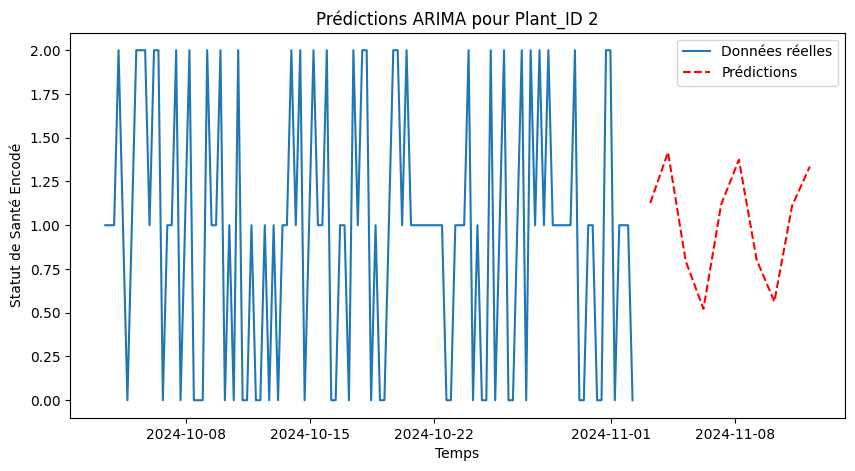


🔮 Prédictions ARIMA pour Plant_ID 3:
120    0.854994
121    1.032062
122    1.004680
123    1.008914
124    1.008259
125    1.008361
126    1.008345
127    1.008347
128    1.008347
129    1.008347
Name: predicted_mean, dtype: float64


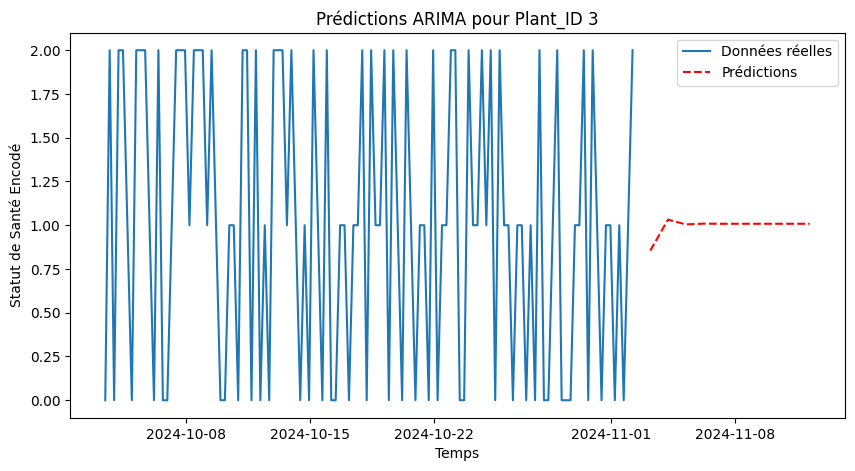


🔮 Prédictions ARIMA pour Plant_ID 4:
120    1.149995
121    1.149995
122    1.149995
123    1.149995
124    1.149995
125    1.149995
126    1.149995
127    1.149995
128    1.149995
129    1.149995
Name: predicted_mean, dtype: float64


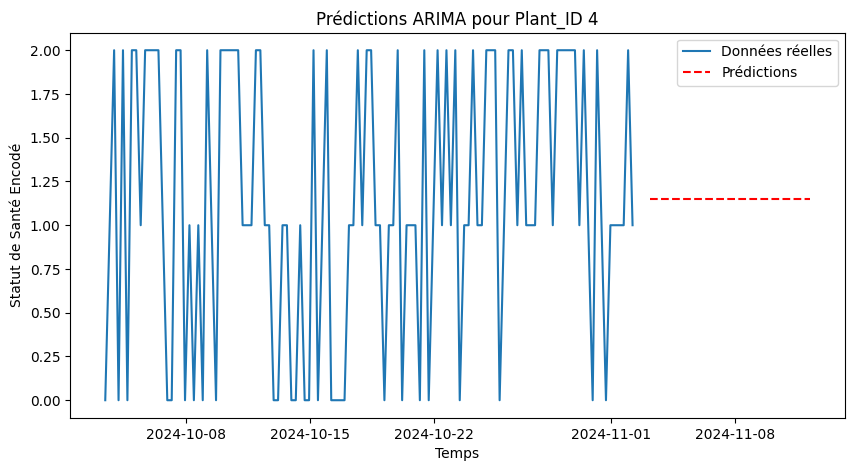


🔮 Prédictions ARIMA pour Plant_ID 5:
120    1.084179
121    1.097276
122    1.099314
123    1.099631
124    1.099680
125    1.099688
126    1.099689
127    1.099689
128    1.099689
129    1.099689
Name: predicted_mean, dtype: float64


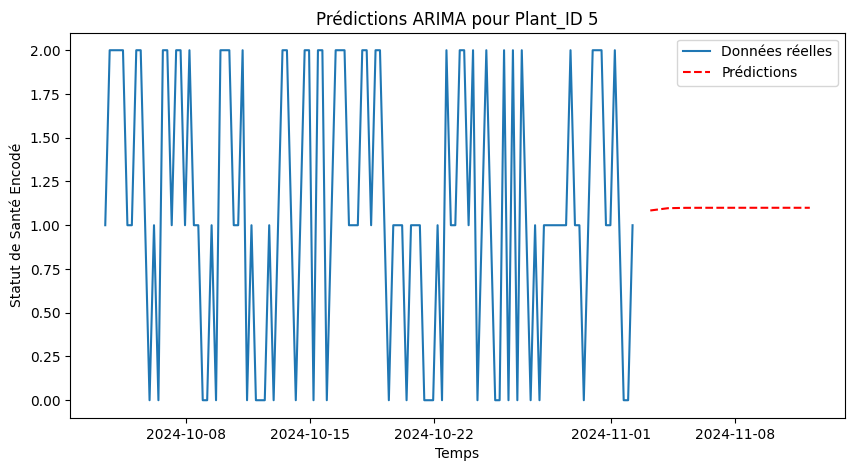


🔮 Prédictions ARIMA pour Plant_ID 6:
120    1.133328
121    1.133328
122    1.133328
123    1.133328
124    1.133328
125    1.133328
126    1.133328
127    1.133328
128    1.133328
129    1.133328
Name: predicted_mean, dtype: float64


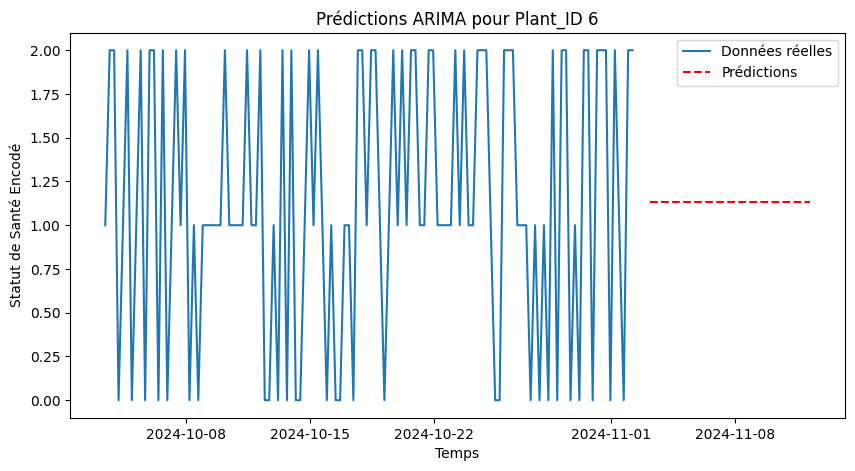


🔮 Prédictions ARIMA pour Plant_ID 7:
120    1.041662
121    1.041662
122    1.041662
123    1.041662
124    1.041662
125    1.041662
126    1.041662
127    1.041662
128    1.041662
129    1.041662
Name: predicted_mean, dtype: float64


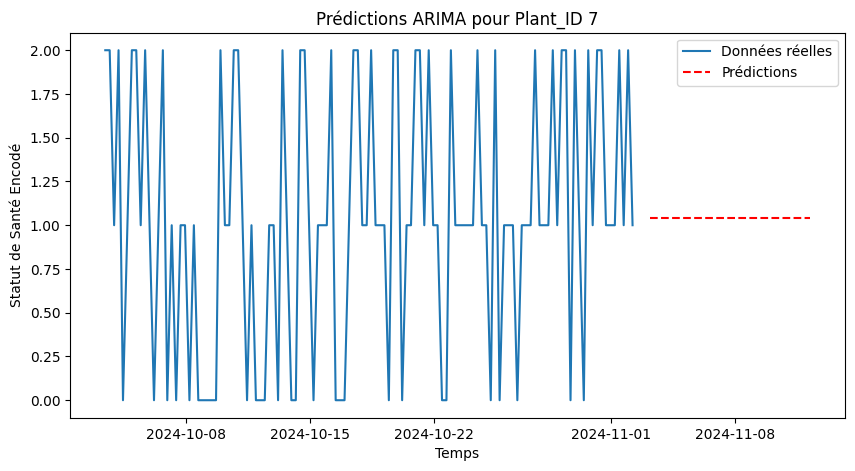


🔮 Prédictions ARIMA pour Plant_ID 8:
120    1.057853
121    1.064821
122    1.099495
123    1.099495
124    1.099495
125    1.099495
126    1.099495
127    1.099495
128    1.099495
129    1.099495
Name: predicted_mean, dtype: float64


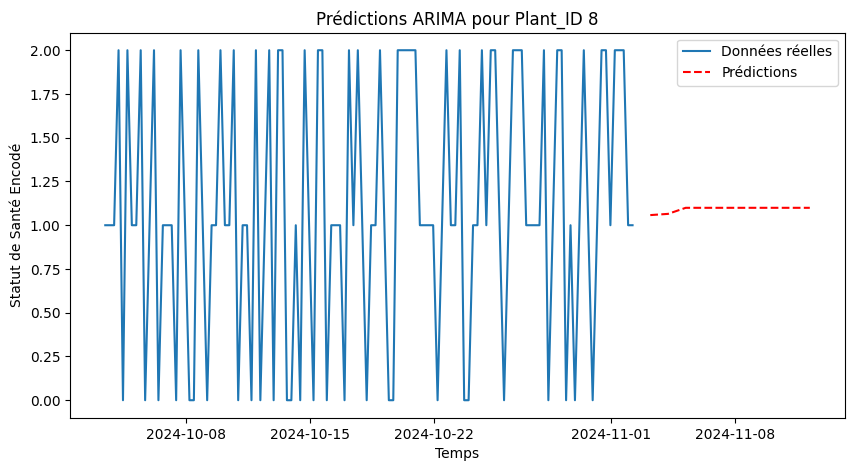


🔮 Prédictions ARIMA pour Plant_ID 9:
120    1.077225
121    1.216675
122    1.075735
123    0.929306
124    1.015090
125    1.155450
126    1.114271
127    0.988568
128    0.995775
129    1.101962
Name: predicted_mean, dtype: float64


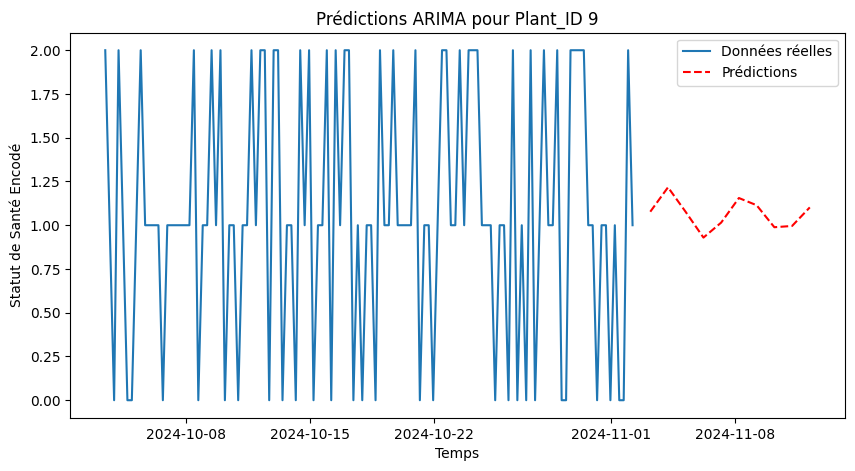


🔮 Prédictions ARIMA pour Plant_ID 10:
120    0.852111
121    1.251321
122    1.295060
123    0.949772
124    1.017134
125    1.284174
126    1.147888
127    0.966661
128    1.134508
129    1.234854
Name: predicted_mean, dtype: float64


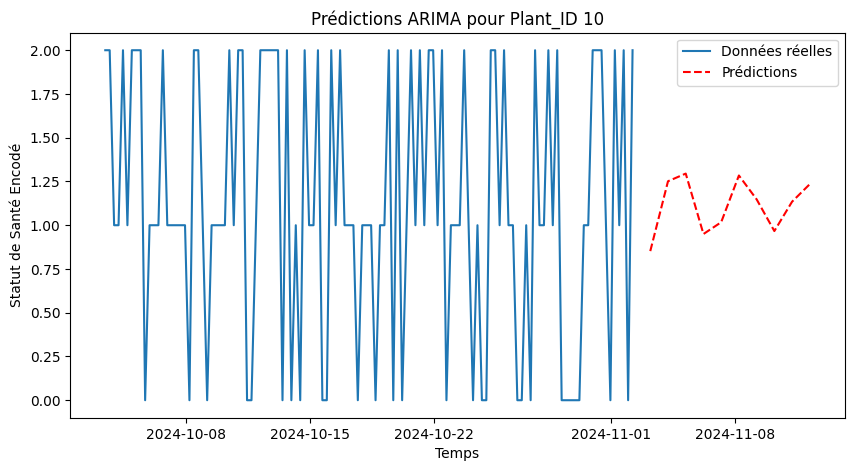

In [52]:
# 🔹 5. Affichage des prédictions
for plant_id, forecast in forecast_results.items():
    print(f'\n🔮 Prédictions ARIMA pour Plant_ID {plant_id}:')
    print(forecast)

    # Tracer les prédictions
    df_plant = df[df['Plant_ID'] == plant_id].copy()
    plt.figure(figsize=(10, 5))
    plt.plot(df_plant['Timestamp'], df_plant['Plant_Health_Status_Encoded'], label='Données réelles')
    future_dates = pd.date_range(df_plant['Timestamp'].max(), periods=len(forecast)+1, freq='D')[1:]
    plt.plot(future_dates, forecast, label='Prédictions', linestyle='dashed', color='red')
    plt.xlabel('Temps')
    plt.ylabel('Statut de Santé Encodé')
    plt.legend()
    plt.title(f'Prédictions ARIMA pour Plant_ID {plant_id}')
    plt.show()
